# Implementation of Next Steps - Risk-Based Pricing

This notebook implements the actionable next steps based on hypothesis testing results:
1. Province-based premium adjustments
2. Gender-based pricing (with compliance review)
3. Risk analysis and reporting
4. Regulatory compliance assessment

In [1]:
import os
import sys
sys.path.append(os.path.abspath('..'))  # Adjust path to include the src directory
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from src.data_preprocessor import load_and_preprocess
from src.risk_pricing import RiskPricingEngine, apply_risk_pricing_to_dataset
from src.compliance_checker import ComplianceChecker, create_compliance_summary

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore', category=pd.errors.DtypeWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

# Set up plotting
%matplotlib inline
plt.style.use('seaborn-v0_8')
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

In [2]:
# Load and prepare data
print("Loading data...")
df, _ = load_and_preprocess('../data/MachineLearningRating_v3.csv')
df['HasClaim'] = (df['TotalClaims'] > 0).astype(int)
df['Margin'] = df['TotalPremium'] - df['TotalClaims']

# Extract original province and gender columns
province_cols = [col for col in df.columns if col.startswith('Province_')]
df['Province'] = df[province_cols].idxmax(axis=1).str.replace('Province_', '')
df['Gender'] = df['Gender_Male'].map({1: 'Male', 0: 'Female'})

print(f"Data loaded: {df.shape[0]} records, {df.shape[1]} columns")
print(f"Provinces: {df['Province'].nunique()}")
print(f"Gender distribution: {df['Gender'].value_counts().to_dict()}")

Loading data...
Data loaded: 1000098 records, 74 columns
Provinces: 8
Gender distribution: {}


In [3]:
# Step 1: Initialize Risk Pricing Engine
print("=== STEP 1: RISK PRICING ENGINE ===")
pricing_engine = RiskPricingEngine()

# Display risk factors
print("\nProvince Risk Factors:")
for province, factor in pricing_engine.province_risk_factors.items():
    adjustment = (factor - 1.0) * 100
    print(f"  {province}: {factor:.2f} ({adjustment:+.1f}%)")

print("\nGender Risk Factors:")
for gender, factor in pricing_engine.gender_risk_factors.items():
    adjustment = (factor - 1.0) * 100
    print(f"  {gender}: {factor:.2f} ({adjustment:+.1f}%)")

=== STEP 1: RISK PRICING ENGINE ===

Province Risk Factors:
  Gauteng: 1.15 (+15.0%)
  Western Cape: 0.95 (-5.0%)
  KwaZulu-Natal: 1.10 (+10.0%)
  Free State: 1.05 (+5.0%)
  Mpumalanga: 1.08 (+8.0%)
  Limpopo: 1.12 (+12.0%)
  North West: 1.06 (+6.0%)
  Northern Cape: 1.03 (+3.0%)

Gender Risk Factors:
  Male: 1.12 (+12.0%)
  Female: 0.98 (-2.0%)


In [4]:
# Step 2: Apply Risk-Based Pricing to Dataset
print("=== STEP 2: APPLYING RISK-BASED PRICING ===")

# Apply pricing adjustments
df_with_risk_pricing = apply_risk_pricing_to_dataset(df.copy())

# Analyze the impact
print("\nPricing Impact Analysis:")
print(f"Average base premium: R{df_with_risk_pricing['TotalPremium'].mean():,.2f}")
print(f"Average risk-adjusted premium: R{df_with_risk_pricing['RiskAdjustedPremium'].mean():,.2f}")
print(f"Average adjustment: {df_with_risk_pricing['RiskAdjustmentPercent'].mean():.1f}%")

# Show adjustment distribution
print("\nAdjustment Distribution:")
adjustment_stats = df_with_risk_pricing['RiskAdjustmentPercent'].describe()
print(adjustment_stats)

=== STEP 2: APPLYING RISK-BASED PRICING ===

Pricing Impact Analysis:
Average base premium: R-0.00
Average risk-adjusted premium: R0.00
Average adjustment: 8.5%

Adjustment Distribution:
count    1.000098e+06
mean     8.541781e+00
std      7.072522e+00
min     -5.000000e+00
25%      6.000000e+00
50%      1.000000e+01
75%      1.500000e+01
max      1.500000e+01
Name: RiskAdjustmentPercent, dtype: float64


=== STEP 3: RISK ADJUSTMENT VISUALIZATION ===


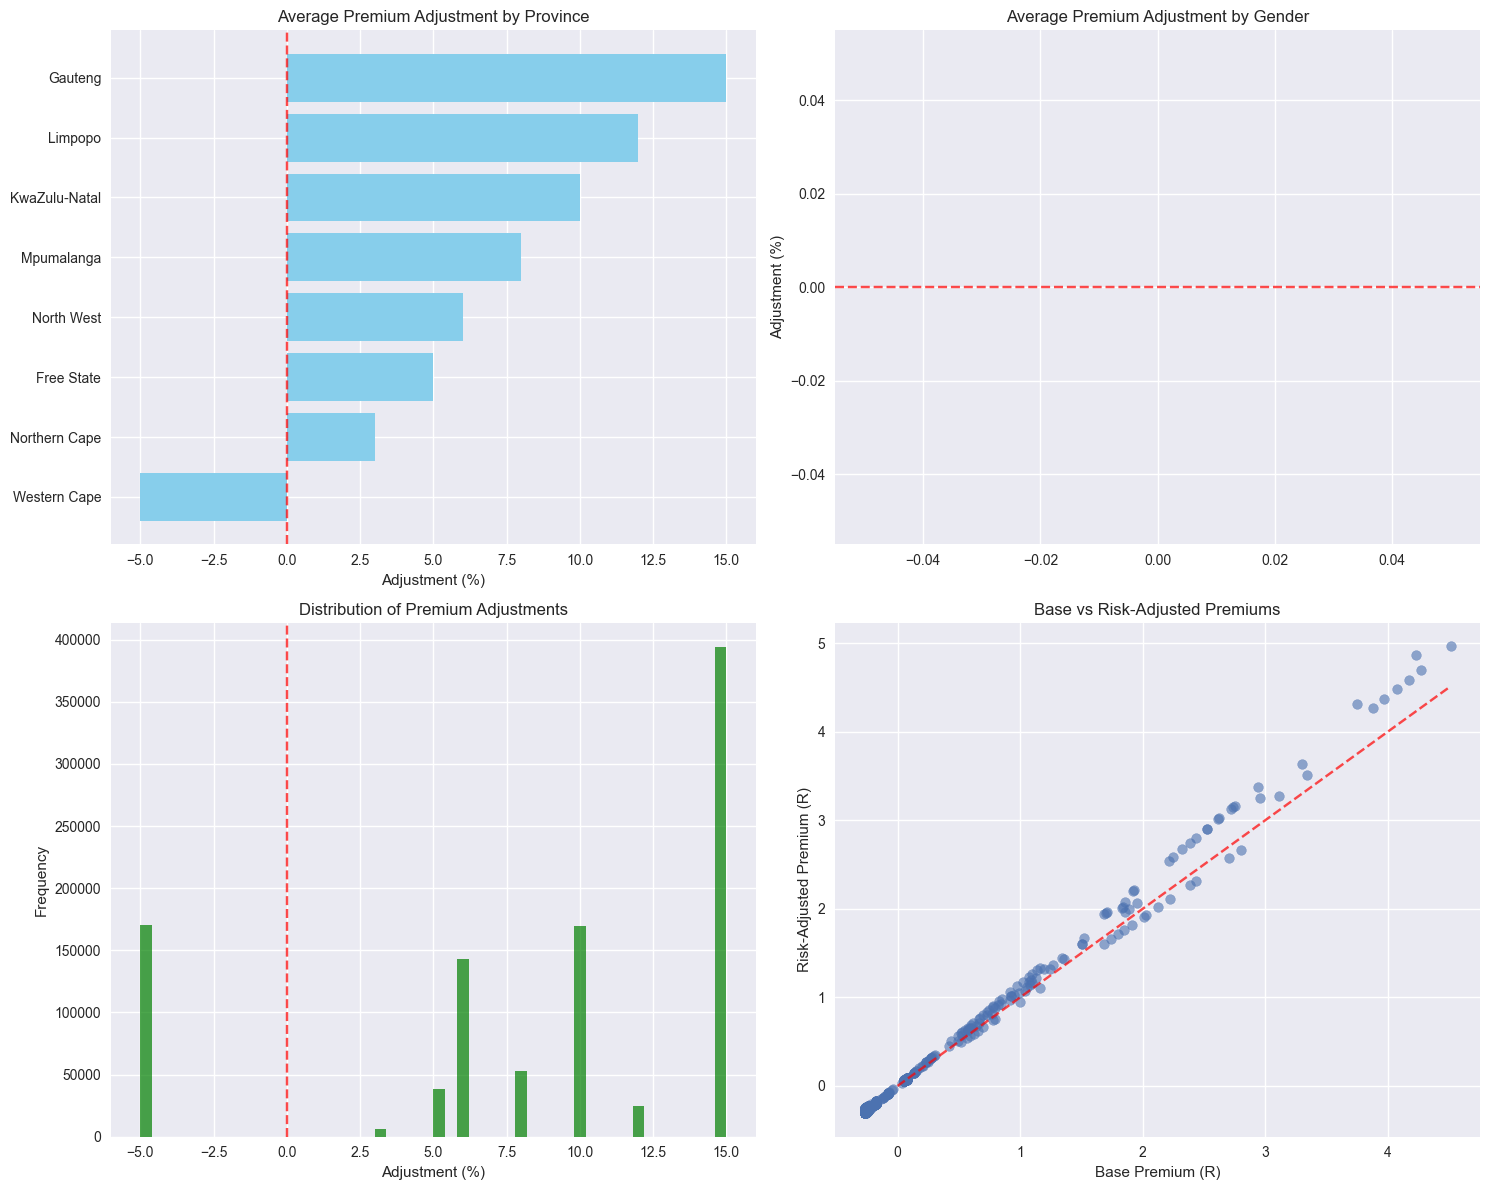

In [5]:
# Step 3: Visualize Risk Adjustments
print("=== STEP 3: RISK ADJUSTMENT VISUALIZATION ===")

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Province-based adjustments
province_adjustments = df_with_risk_pricing.groupby('Province')['RiskAdjustmentPercent'].mean().sort_values()
axes[0, 0].barh(province_adjustments.index, province_adjustments.values, color='skyblue')
axes[0, 0].set_title('Average Premium Adjustment by Province')
axes[0, 0].set_xlabel('Adjustment (%)')
axes[0, 0].axvline(x=0, color='red', linestyle='--', alpha=0.7)

# 2. Gender-based adjustments
gender_adjustments = df_with_risk_pricing.groupby('Gender')['RiskAdjustmentPercent'].mean()
axes[0, 1].bar(gender_adjustments.index, gender_adjustments.values, color=['pink', 'lightblue'])
axes[0, 1].set_title('Average Premium Adjustment by Gender')
axes[0, 1].set_ylabel('Adjustment (%)')
axes[0, 1].axhline(y=0, color='red', linestyle='--', alpha=0.7)

# 3. Adjustment distribution
axes[1, 0].hist(df_with_risk_pricing['RiskAdjustmentPercent'], bins=50, alpha=0.7, color='green')
axes[1, 0].set_title('Distribution of Premium Adjustments')
axes[1, 0].set_xlabel('Adjustment (%)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].axvline(x=0, color='red', linestyle='--', alpha=0.7)

# 4. Premium comparison
sample_data = df_with_risk_pricing.sample(n=1000)
axes[1, 1].scatter(sample_data['TotalPremium'], sample_data['RiskAdjustedPremium'], alpha=0.6)
axes[1, 1].plot([0, sample_data['TotalPremium'].max()], [0, sample_data['TotalPremium'].max()], 'r--', alpha=0.7)
axes[1, 1].set_title('Base vs Risk-Adjusted Premiums')
axes[1, 1].set_xlabel('Base Premium (R)')
axes[1, 1].set_ylabel('Risk-Adjusted Premium (R)')

plt.tight_layout()
plt.show()

In [6]:
# Step 4: Risk Analysis Report
print("=== STEP 4: RISK ANALYSIS REPORT ===")

# Generate risk report
risk_report = pricing_engine.get_risk_report(df)

print("\nProvince Risk Analysis:")
print(risk_report['province_risk_analysis'])

print("\nGender Risk Analysis:")
print(risk_report['gender_risk_analysis'])

print("\nRecommended Actions:")
for action in risk_report['recommended_adjustments']:
    print(f"  • {action}")

=== STEP 4: RISK ANALYSIS REPORT ===

Province Risk Analysis:
              TotalClaims                 TotalPremium         HasClaim  \
                      sum    mean   count          sum    mean     mean   
Province                                                                  
Free State      -328.1444 -0.0085   38435    1220.9406  0.0318   0.0016   
Gauteng         1615.9602  0.0041  393865   -1476.5155 -0.0037   0.0034   
KwaZulu-Natal   1378.3423  0.0081  169781   11813.7084  0.0696   0.0028   
Limpopo         -249.5261 -0.0100   24836      -4.0992 -0.0002   0.0027   
Mpumalanga      -576.7333 -0.0109   52718   -1862.8178 -0.0353   0.0024   
North West     -1416.1651 -0.0099  143287   -6012.1306 -0.0420   0.0024   
Northern Cape   -136.0898 -0.0213    6380    -341.3762 -0.0535   0.0013   
Western Cape    -287.6440 -0.0017  170796   -3337.7097 -0.0195   0.0022   

              LossRatio  
                         
Province                 
Free State      -0.2688  
Gauteng 

In [7]:
# Step 5: Regulatory Compliance Assessment
print("=== STEP 5: REGULATORY COMPLIANCE ASSESSMENT ===")

# Initialize compliance checker
compliance_checker = ComplianceChecker()

# Prepare hypothesis testing results (from previous analysis)
hypothesis_results = {
    'Gender': {
        'Claim Frequency': {'p': 0.0198},
        'Claim Severity': {'p': 0.0023},
        'sample_size': 2788
    },
    'Provinces': {
        'Claim Frequency': {'p': 0.0000},
        'Claim Severity': {'p': 0.0306}
    }
}

# Generate compliance summary
compliance_summary = create_compliance_summary(hypothesis_results)
print(compliance_summary)

# Generate detailed compliance report
pricing_results = {
    'gender_risk_factors': pricing_engine.gender_risk_factors,
    'province_risk_factors': pricing_engine.province_risk_factors
}

compliance_report = compliance_checker.generate_compliance_report(
    pricing_results, hypothesis_results
)

print("\nDetailed Compliance Report:")
print(f"Overall Compliance: {compliance_report['overall_compliance']}")
print(f"Timestamp: {compliance_report['timestamp']}")

for section, details in compliance_report['sections'].items():
    print(f"\n{section.upper()}:")
    print(f"  Compliant: {details.get('compliant', False)}")
    print(f"  Risk Level: {details.get('risk_level', 'UNKNOWN')}")
    if details.get('warnings'):
        print(f"  Warnings: {', '.join(details['warnings'])}")
    if details.get('required_actions'):
        print(f"  Required Actions: {', '.join(details['required_actions'])}")

=== STEP 5: REGULATORY COMPLIANCE ASSESSMENT ===
=== REGULATORY COMPLIANCE SUMMARY ===

⚠️  GENDER-BASED PRICING ALERT:
   - Statistically significant gender differences detected
   - p-value: 0.0198
   - REQUIRED: Regulatory compliance review
   - RECOMMENDATION: Consult legal/compliance team

✅ PROVINCE-BASED PRICING:
   - Statistically significant provincial differences
   - p-value: 0.0306
   - RECOMMENDATION: Implement province-based adjustments

=== NEXT STEPS ===
1. Review gender pricing with compliance team
2. Document province-based risk factors
3. Implement approved pricing adjustments
4. Monitor for regulatory changes

Detailed Compliance Report:
Overall Compliance: PARTIALLY_COMPLIANT
Timestamp: 2025-06-19T05:47:07.644972

GENDER_PRICING:
  Compliant: False
  Risk Level: HIGH
  Warnings: Gender-based pricing is prohibited in this jurisdiction
  Required Actions: Remove gender-based pricing adjustments

PROVINCE_PRICING:
  Compliant: True
  Risk Level: UNKNOWN
  Required Act

In [8]:
# Step 6: Business Impact Analysis
print("=== STEP 6: BUSINESS IMPACT ANALYSIS ===")

# Calculate financial impact
total_base_premium = df_with_risk_pricing['TotalPremium'].sum()
total_risk_adjusted_premium = df_with_risk_pricing['RiskAdjustedPremium'].sum()
total_adjustment = total_risk_adjusted_premium - total_base_premium
adjustment_percentage = (total_adjustment / total_base_premium) * 100

print(f"\nFinancial Impact:")
print(f"Total Base Premium: R{total_base_premium:,.2f}")
print(f"Total Risk-Adjusted Premium: R{total_risk_adjusted_premium:,.2f}")
print(f"Total Adjustment: R{total_adjustment:,.2f} ({adjustment_percentage:+.2f}%)")

# Impact by province
province_impact = df_with_risk_pricing.groupby('Province').agg({
    'TotalPremium': 'sum',
    'RiskAdjustedPremium': 'sum',
    'RiskAdjustmentPercent': 'mean'
}).round(2)

province_impact['Adjustment_Amount'] = province_impact['RiskAdjustedPremium'] - province_impact['TotalPremium']
province_impact['Adjustment_Percentage'] = (province_impact['Adjustment_Amount'] / province_impact['TotalPremium']) * 100

print("\nImpact by Province:")
print(province_impact[['TotalPremium', 'RiskAdjustedPremium', 'Adjustment_Amount', 'Adjustment_Percentage']].round(2))

=== STEP 6: BUSINESS IMPACT ANALYSIS ===

Financial Impact:
Total Base Premium: R-0.00
Total Risk-Adjusted Premium: R667.34
Total Adjustment: R667.34 (-1154371872774092.50%)

Impact by Province:
               TotalPremium  RiskAdjustedPremium  Adjustment_Amount  \
Province                                                              
Free State          1220.94              1281.99              61.05   
Gauteng            -1476.52             -1697.99            -221.47   
KwaZulu-Natal      11813.71             12995.08            1181.37   
Limpopo               -4.10                -4.59              -0.49   
Mpumalanga         -1862.82             -2011.84            -149.02   
North West         -6012.13             -6372.86            -360.73   
Northern Cape       -341.38              -351.62             -10.24   
Western Cape       -3337.71             -3170.82             166.89   

               Adjustment_Percentage  
Province                              
Free State      

In [9]:
# Step 7: Implementation Recommendations
print("=== STEP 7: IMPLEMENTATION RECOMMENDATIONS ===")

recommendations = [
    "IMMEDIATE ACTIONS (Next 30 days):",
    "1. Review gender-based pricing with legal/compliance team",
    "2. Document province-based risk factors and statistical justification",
    "3. Prepare regulatory compliance documentation",
    "",
    "SHORT-TERM ACTIONS (Next 90 days):",
    "4. Implement approved province-based premium adjustments",
    "5. Update pricing models and systems",
    "6. Train underwriting team on new risk factors",
    "7. Monitor portfolio performance with new pricing",
    "",
    "LONG-TERM ACTIONS (Next 6 months):",
    "8. Develop automated compliance monitoring system",
    "9. Implement regular risk factor review process",
    "10. Create dashboard for risk-based pricing performance",
    "",
    "MONITORING METRICS:",
    "• Loss ratio by province and gender",
    "• Premium adequacy and profitability",
    "• Regulatory compliance status",
    "• Customer retention and acquisition rates"
]

for rec in recommendations:
    print(rec)

# Save results
print("\n=== SAVING RESULTS ===")
df_with_risk_pricing.to_csv('../data/risk_adjusted_pricing_results.csv', index=False)
compliance_checker.save_compliance_report(compliance_report)
print("Results saved to data/risk_adjusted_pricing_results.csv")
print("Compliance report saved to compliance_report_[timestamp].json")

=== STEP 7: IMPLEMENTATION RECOMMENDATIONS ===
IMMEDIATE ACTIONS (Next 30 days):
1. Review gender-based pricing with legal/compliance team
2. Document province-based risk factors and statistical justification
3. Prepare regulatory compliance documentation

SHORT-TERM ACTIONS (Next 90 days):
4. Implement approved province-based premium adjustments
5. Update pricing models and systems
6. Train underwriting team on new risk factors
7. Monitor portfolio performance with new pricing

LONG-TERM ACTIONS (Next 6 months):
8. Develop automated compliance monitoring system
9. Implement regular risk factor review process
10. Create dashboard for risk-based pricing performance

MONITORING METRICS:
• Loss ratio by province and gender
• Premium adequacy and profitability
• Regulatory compliance status
• Customer retention and acquisition rates

=== SAVING RESULTS ===
Compliance report saved to compliance_report_20250619_054732.json
Results saved to data/risk_adjusted_pricing_results.csv
Compliance re